In [106]:
%matplotlib inline

import numpy as np
import scipy.io.wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio 

In [7]:
!cd ../DATA/audio_samples/with_annotations/desk3;ls

MIDIout.wav	   n_training_onsets~  onsets2kick.csv	 train1snare.wav
mix1.wav	   onsets1snare.csv    onsets3hh.csv	 train2kick.wav
n_training_onsets  onsets1snare.csv~   sonicvis_file.sv  train3hihiat.wav


In [10]:
DATA_DIR = "../DATA/audio_samples/with_annotations/desk3/"

# load and inspect wave file

In [39]:
audio_filename = "train1snare.wav"

In [40]:
fs, data = scipy.io.wavfile.read(DATA_DIR + audio_filename)

/home/jefe/anaconda3/lib/python3.5/site-packages/scipy/io/wavfile.py:221: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [36]:
def plot_audio(data, fs, **kwargs):
    del_t = 1/fs
    t = np.arange(len(data))*del_t
    plt.plot(t, data, **kwargs)
    plt.xlabel('t [sec]')
    plt.ylabel('amplitude')

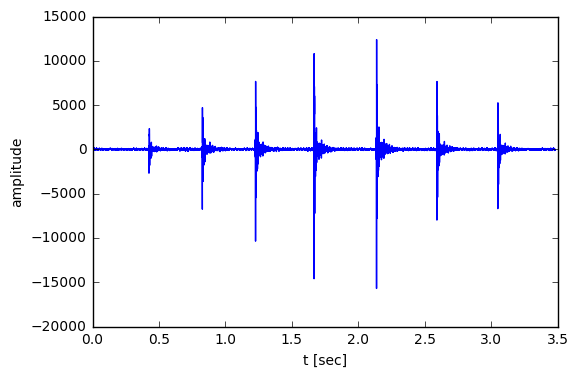

In [37]:
plot_audio(data, fs)

In [28]:
Audio(data, rate=fs)

/home/jefe/anaconda3/lib/python3.5/site-packages/scipy/io/wavfile.py:221: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


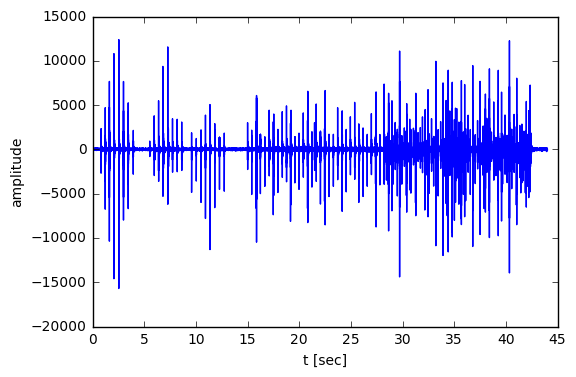

In [57]:
audio_filename = 'mix1.wav'
fs, data = scipy.io.wavfile.read(DATA_DIR + audio_filename)
plot_audio(data, fs)

In [58]:
Audio(data, rate=fs)

# read annotations

In [43]:
annotations_filename = 'onsets1snare.csv'

In [56]:
annotations = pd.read_csv(DATA_DIR + annotations_filename, header=None, usecols=[0])[0].values

In [67]:
def plot_annotations(annotations, **kwargs):
    [plt.axvline(a, **kwargs) for a in annotations]

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


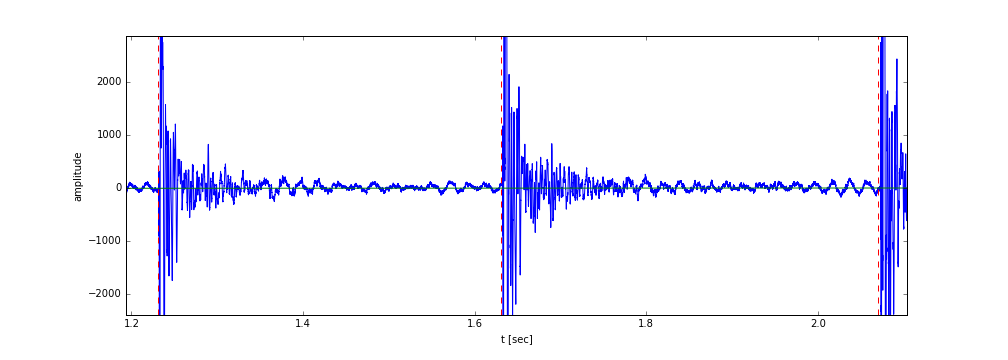

In [79]:
%matplotlib auto
plt.figure(figsize=(14,5))
plot_audio(data, fs)
plot_annotations(annotations, color='r', linestyle='--')

# define params

In [92]:
class DictAttr(dict):
    """Dict with dot access

    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        for arg in args:
            if isinstance(arg, dict):
                for k, v in arg.items():
                    self[k] = v

        if kwargs:
            for k, v in kwargs.items():
                self[k] = v

    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, key, value):
        self.__setitem__(key, value)

    def __setitem__(self, key, value):
        super().__setitem__(key, value)
        self.__dict__.update({key: value})

    def __delattr__(self, item):
        self.__delitem__(item)

    def __delitem__(self, key):
        super().__delitem__(key)
        del self.__dict__[key]

In [87]:
config = DictAttr()

In [94]:
hopsize = 128*2
framesize = 512*2

In [96]:
hopsize_t = 1/fs*hopsize
framesize_t = 1/fs*framesize

# fft

In [299]:
t = np.linspace(0, 100, 1000)
f = 3
x = np.sin(2*np.pi*f*t)

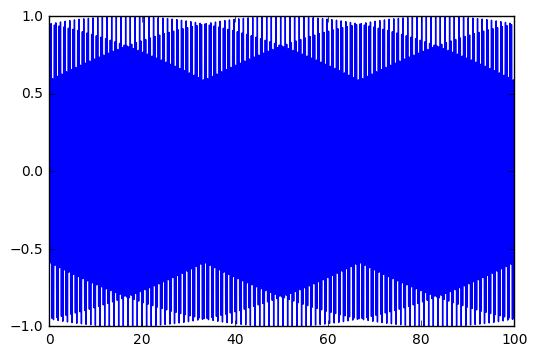

In [300]:
plt.plot(t, x)

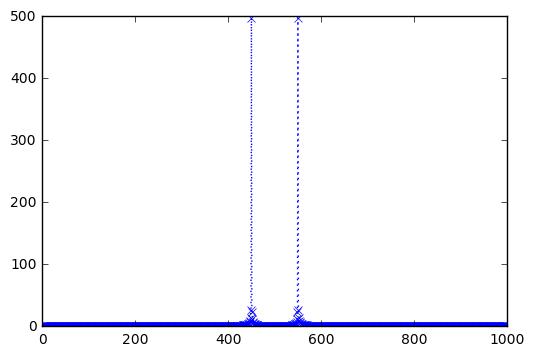

In [277]:
tranformed = np.fft.fftshift(np.fft.fft(x))
plt.plot(abs(tranformed), ':x')

/home/jefe/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/home/jefe/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


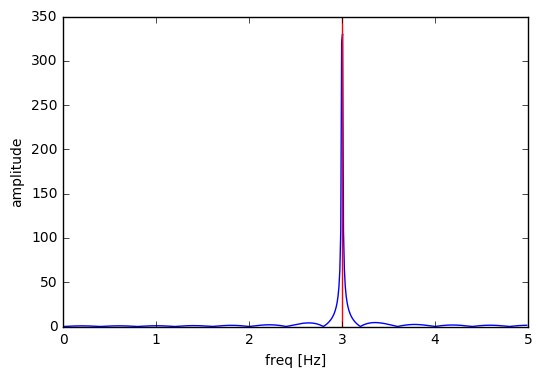

In [359]:
fs = 1/(t[1]-t[0])
freqs = np.fft.fftfreq(nextpow2(len(x)), 1/fs)[:nextpow2(len(x))/2]
plt.plot(freqs, magnitude_spectrum(x))
plt.axvline(f, color='r')
plt.ylabel("amplitude")
plt.xlabel("freq [Hz]");



In [343]:
def nextpow2(i):
    n = 2
    while n < i: n = n * 2
    return n

def magnitude_spectrum(s, window=None):
    l = nextpow2(len(s))  # is this needed?
    S = np.fft.fft(s, l)
    S_pos = S[0:l/2]  # retain only positive frequencies
    return abs(S_pos)  # magnitude spektrum

def zero_pad(s, desired_length):
    return np.pad(s, (0, desired_length - len(s)), mode='constant')

def sfft(s, hopsize, framesize, window=None):
    n_samples = len(s)  
    n_frames = int(np.floor(n_samples/hopsize))

    # zero-padding of the input vector so that it fits all frames
    desired_len = int(n_frames*hopsize + framesize)
    s = zero_pad(s, desired_len)

    # initialize
    size = int(nextpow2(framesize)/2)
    res = np.zeros([size, n_frames])

    for frame in range(n_frames):  
        start = (frame-1)*hopsize
        current_block = range(start, start + framesize)
        res[:,frame] = magnitude_spectrum(s[current_block], window)
    return res

/home/jefe/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/jefe/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


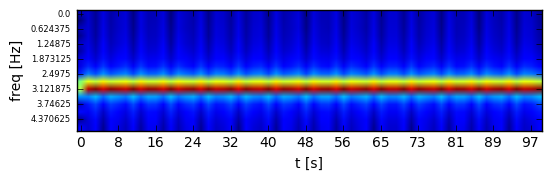

In [371]:
framesize = 32
hopsize = 16

spectrogram = sfft(x, hopsize, framesize)
freqs = np.fft.fftfreq(framesize, 1/fs)[:framesize/2]


plt.imshow(spectrogram)

plt.gca().set_yticks(range(int(framesize/2))[::2])
plt.gca().set_yticklabels(freqs[::2], fontsize=6)

plt.gca().set_xticks(range(spectrogram.shape[1])[::5])
plt.gca().set_xticklabels(np.linspace(0, spectrogram.shape[1]*hopsize/fs, spectrogram.shape[1]).astype(int)[::5])

plt.ylabel("freq [Hz]");
plt.xlabel("t [s]");